# In this notebook we will change Keras(Cifar10 dataset model) to MDF

Using the function define in [**MDF\\examples\\TensorFlow\\Keras**]

In [1]:
# import sys to temporarily add files to sys path 
import sys

# add dir path of the keras2mdf helper function
sys.path.append("C:\\Users\\Rishikesh Maurya\\MDF\\examples\\TensorFlow\\Keras")

# access every function in keras2mdf
from keras2mdf import *

### Import Necessary Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from keras.utils.vis_utils import plot_model
import numpy as np

### Splitting into training and Testing

In [32]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)#Splitting the x_train with 50000 datasets
print(x_test.shape)#Splitting the x_test with 10000 datasets of image

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Normalizing the Image

In [33]:
# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

### KERAS MODEL

In [34]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


### Adding the optimizer and loss function

In [35]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Fitting the model for training the model

In [49]:
# Train the model
model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6002 - accuracy: 0.4299 - val_loss: 1.5846 - val_accuracy: 0.4345
Epoch 2/20
1563/1563 [==============================] - 13s 9ms/step - loss: 1.5831 - accuracy: 0.4365 - val_loss: 1.5850 - val_accuracy: 0.4362
Epoch 3/20
1563/1563 [==============================] - 13s 9ms/step - loss: 1.5737 - accuracy: 0.4404 - val_loss: 1.5645 - val_accuracy: 0.4377
Epoch 4/20
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5593 - accuracy: 0.4459 - val_loss: 1.6585 - val_accuracy: 0.4201
Epoch 5/20
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5475 - accuracy: 0.4483 - val_loss: 1.6520 - val_accuracy: 0.4086
Epoch 6/20
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5410 - accuracy: 0.4524 - val_loss: 1.5638 - val_accuracy: 0.4387
Epoch 7/20
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5291 - accuracy: 0.4556 - val_loss: 1.5980 - val_a

### Evaluation of Model

In [50]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)# Testing the accuracy/

313/313 [==============================] - 1s 2ms/step - loss: 1.5392 - accuracy: 0.4573
Test accuracy: 0.45730000734329224


The above accuracy is very low we can add some other layers increase epocs and change optimizer function for improving the
accuracy but for now I will go with this simple model

In [53]:
Prediction=model.predict(x_test[1].reshape(1,32,32,3))
print("The predicted number at index 1 is", np.argmax(Prediction))

1/1 [==============================] - 0s 5ms/step
The predicted number at index 1 is 9


In [56]:
y_test[1]

array([8], dtype=uint8)

###  Graph Generate

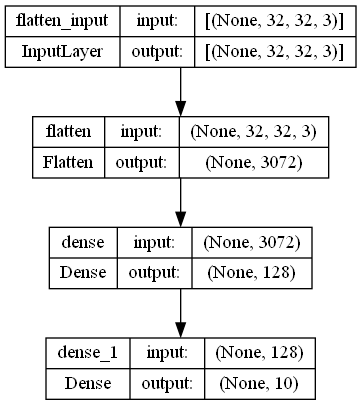

In [9]:
#Plotting the Cifar10 model 
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

### Layers in the model for generating nodes in MDF

In [10]:
for x in model.layers:
    print(x.name)

flatten
dense
dense_1


In [11]:
layers_to_extract = [ "dense", "dense_1"]

### Params and activation function values from layer of Keras model

In [12]:
params, activations = get_weights_and_activation(layers_to_extract, model)
# creating the model and graph from init_model_with_graph

mod, mod_graph = init_model_with_graph("keras_to_MDF", "Keras_to_MDF_graph")
#checking the input shape of the first dense layer of the keras model

model.layers[1].input_shape

(None, 3072)

### Changing the shape of X_train for MDF input node 

In [13]:
x_train =x_train[0, :, :]

In [14]:
x_train.shape

(32, 32, 3)

In [15]:
input = x_train.reshape(1,32,32,3)

In [16]:
input_value = input.reshape(3072,)


input_value.shape

(3072,)

## Input node

In [17]:
# create input node for the mdf model

input_node = create_input_node("input_node", input_value)

# append the input node to the graph

mod_graph.nodes.append(input_node)

## 1st Dense node

In [18]:
weights = params["dense"]["weights"]
bias = params["dense"]["bias"]

# create first dense node of the model
dense_node = create_dense_node("dense_node", weights, bias)

#append the dense node to the graph
mod_graph.nodes.append(dense_node)

## Adding activation function to node

In [19]:
#create activation on the first dense node
activation_node = create_activation_node("activation_node",  activations[0])

#append the activation node to the graph
mod_graph.nodes.append(activation_node)

# 2nd Dense node

In [20]:
weights_1 = params["dense_1"]["weights"]
bias_1= params["dense_1"]["bias"]

#create second dense noe
dense1_node = create_dense_node("dense1_node", weights_1, bias_1)

#append second dense node to the graph
mod_graph.nodes.append(dense1_node)

## 2nd activation function

In [21]:
#create activation on the second dense node
activation1_node = create_activation_node("activation1_node",  activations[1])

#append the second activation node to the graph
mod_graph.nodes.append(activation1_node)

### Connecting all the nodes

In [22]:
e1 = simple_connect(input_node, dense_node, mod_graph)
e2 = simple_connect(dense_node, activation_node, mod_graph)
e3 = simple_connect(activation_node, dense1_node, mod_graph)
e4 = simple_connect(dense1_node, activation1_node, mod_graph)


### Generating the Graph image

Converting MDF graph: Keras_to_MDF_graph to graphviz (level: 1, format: png)
    Node: input_node
    Node: dense_node
    Node: activation_node
    Node: dense1_node
    Node: activation1_node
    Edge: edge_input_node_dense_node connects input_node to dense_node
    Edge: edge_dense_node_activation_node connects dense_node to activation_node
    Edge: edge_activation_node_dense1_node connects activation_node to dense1_node
    Edge: edge_dense1_node_activation1_node connects dense1_node to activation1_node
Written graph image to: keras_to_MDF.png


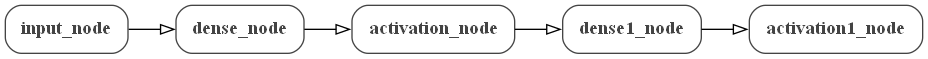

In [23]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=1,
        filename_root="keras_to_MDF",
        is_horizontal=True, 
)

from IPython.display import Image
Image(filename="Keras_to_MDF.png")

### Evaluating the MDF model

In [24]:
eg = EvaluableGraph(mod_graph, verbose=False)

# evaluating the model 
eg.evaluate()


Init graph: Keras_to_MDF_graph
Evaluating graph: Keras_to_MDF_graph, root nodes: ['input_node'], with array format numpy


### Output of MDF model

In [57]:
mdf_prediction = eg.enodes["activation1_node"].evaluable_outputs["activation1_node_out"].curr_value

mdf_prediction.argmax()

6

### Keras model prediction

In [58]:
model.predict(input, batch_size=1).argmax()

1/1 [==============================] - 0s 16ms/step


6

# The above both predicted the same output